In [1]:
from sklearn.datasets._samples_generator import check_array, check_random_state, make_low_rank_matrix
import numpy as np
from sklearn.utils import shuffle as util_shuffle
import matplotlib.pyplot as plt

from collections import deque
from scipy.stats import rankdata

In [582]:
class LMC(object):
    def __init__(self, dimension, lbd, eta):
        self.dimension = dimension
        self.lbd = lbd
        self.eta = eta
        
    def gradient(self, V, b, theta):
        return (V @ theta) - b
        
    def update_mean(self, mean, gradient, h):
        noise = np.random.normal(0, np.sqrt(2 * h / self.eta), size=(self.dimension,))
        return mean - h * gradient +  noise 
        
    def run(self, x, y, h, max_iter, eps):
        theta=np.zeros(self.dimension)
        V = self.lbd * np.eye(self.dimension) + x.T@x
        b = y @ x
        true_param = np.linalg.inv(V) @ b
        thetas = []
        nb_iter, distances = 0, [np.linalg.norm(true_param - theta, ord=2)]
        
        while nb_iter < max_iter and distances[-1] > eps:
            grad = self.gradient(V, b, theta)
            theta = self.update_mean(theta, grad, h)
            thetas.append(theta)
            if nb_iter > 50:
                thetas.append(theta)
                mean = np.mean(thetas, axis=0)
                distances.append(np.linalg.norm(true_param - mean, ord=2))
            else:
                distances.append(np.linalg.norm(true_param - theta, ord=2))
            nb_iter += 1
        return distances


In [575]:
class VI_gaussian(object):

    def __init__(self, dimension, eta, lbd,  approx=True):
        self.dimension = dimension
        self.approx = approx
        self.eta = eta
        self.lbd = lbd

    def gradient(self, V, b, theta):
        return (self.eta * (V @ theta - b))
        
    def update_mean(self, mean, gradient, h):
        return mean - h * gradient
    
    def update_cov(self, cov_semi, cov_semi_inv, hessian, h):
        cov_semi = (np.eye(self.dimension) - h * hessian) @ cov_semi + h * cov_semi_inv.T
        if self.approx:
            cov_semi_inv = cov_semi_inv @ (np.eye(self.dimension) - h * (np.matmul(cov_semi_inv.T , cov_semi_inv) - hessian))
        else:
            cov_semi_inv = np.linalg.pinv(cov_semi)
        return cov_semi, cov_semi_inv
    
    def sample(self, mean, cov_semi):
        eps = np.random.normal( size=(self.dimension, 1))
        theta = mean.T + (cov_semi @ eps).squeeze()
        return  theta.squeeze()
    
    def run(self, x, y, h, max_iter, eps, true_param):
        mean = np.random.normal(0, 1 / np.sqrt(self.lbd * self.eta), size=(dimension,))
        cov_semi = np.sqrt(1 / (self.eta * self.lbd)) * np.eye(self.dimension)
        cov_semi_inv = np.sqrt((self.eta * self.lbd)) * np.eye(self.dimension)
        V = self.lbd*np.eye(self.dimension) + x.T@x
        b = y @ x
        
        hessian = self.eta * V
        nb_iter, distances = 0, [np.linalg.norm(true_param-mean,ord=2)]
        while nb_iter < max_iter and distances[-1] > eps:
            nb_iter += 1
            theta = self.sample(mean, cov_semi)
            grad = self.gradient(V, b, theta)
            mean = self.update_mean(mean, grad, h)
            cov_semi, cov_semi_inv = self.update_cov(cov_semi, cov_semi_inv, hessian, h)
            distances.append(np.linalg.norm(true_param-mean,ord=2))
        return distances
   

In [576]:
from tqdm.notebook import tqdm

def compute_condition_number(x):
    Sigma = eta * (lbd*np.eye(dimension) + x.T@x)
    return np.linalg.cond(Sigma) 

def generate_data(T, dimension, rank, true_weights):
    x = make_low_rank_matrix(n_samples=T, n_features=dimension,effective_rank=rank)
    x /= np.linalg.norm(x, 2, axis=1, keepdims=True)
    y = x @ true_weights
    return x, y

#def generate_data(T, dimension, kappa, true_weight):
#    x = make_low_rank_matrix(n_samples=T, n_features=dimension, effective_rank=50)
#    eigenvalues, P = np.linalg.eig(x.T @ x)
#    D = P.T @ (x.T @ x) @ P
#    idx = np.argmax(np.diag(D))
#    D[idx, idx] *= kappa * (lbd + np.min(eigenvalues)) - lbd
#    D = np.diag(np.diag(D))
#    M = np.sqrt(D) @ P.T
#    M = np.repeat(M, 50, axis=0)
#    y = M @ true_weight
#    return M, y


def plot_func(T, dimension, nb_seeds, data, h_values, max_iter, eps):
    seeds = np.arange(nb_seeds)
    distance_lmc = np.zeros((len(h_values), nb_seeds, len(data)))
    distance_vi_approx = np.zeros((len(h_values), nb_seeds, len(data)))
    distance_vi_non_approx = np.zeros((len(h_values), nb_seeds, len(data)))
    condition_number = np.zeros((len(h_values), nb_seeds, len(data)))
    
    langevin = LMC(dimension, eta, lbd)
    vi_approx = VI_gaussian(dimension, eta, lbd,  approx=True)
    vi_non_approx = VI_gaussian(dimension, eta, lbd,  approx=False)
    true_weights = np.random.normal(0, 1, size=(dimension,))
    true_weights /= np.linalg.norm(true_weights, ord=2)
    
    for id_data, (cond, x) in enumerate(data.values()):
        y = x @ true_weights
        for h_idx, h in enumerate(h_values):
            for id_seed, seed in enumerate(seeds):
                np.random.seed(seed)
                distance_lmc[h_idx, id_seed, id_data] = len(langevin.run(x, y, h, max_iter, eps, true_weights))
                distance_vi_approx[h_idx, id_seed, id_data] = len(vi_approx.run(x, y, h, max_iter, eps, true_weights))
                distance_vi_non_approx[h_idx, id_seed, id_data] = len(vi_approx.run(x, y, h, max_iter, eps, true_weights))
                condition_number[h_idx, id_seed, id_data] = cond
                print('[SYSTEM]', seed, h, cond, f'lgv: {distance_lmc[h_idx, id_seed, id_data]}',  f'vi: {distance_vi_approx[h_idx, id_seed, id_data]}')
                
    return distance_lmc, distance_vi_approx, distance_vi_non_approx, condition_number

    
dimension = 50
nb_seeds = 1
h_values = [1e-4]
T = 50000
max_iter = 10000
eps = 0.6
eta = 1
lbd = 0.0001

    
dist_lmc, dist_vi_approx, dist_vi_non_approx, cond = plot_func(T, dimension, nb_seeds, result, h_values, max_iter, eps)

[SYSTEM] 0 0.0001 3.0284609692254887 lgv: 10001.0 vi: 116.0
[SYSTEM] 0 0.0001 4.026679798183276 lgv: 10001.0 vi: 137.0
[SYSTEM] 0 0.0001 4.966267182198532 lgv: 10001.0 vi: 156.0
[SYSTEM] 0 0.0001 6.022170286257623 lgv: 10001.0 vi: 165.0
[SYSTEM] 0 0.0001 7.021455870035063 lgv: 10001.0 vi: 163.0
[SYSTEM] 0 0.0001 8.148089946245888 lgv: 10001.0 vi: 163.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

    
def boxplot(h_idx, h_list, dist_lmc, dist_vi_approx, dist_vi_non_approx, cond):
    def add_label(violin, label, labels):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))
        return labels
    plt.figure(figsize=(10, 7))
    condition_numbers = cond[h_idx, 0, :]
    labels = add_label(plt.violinplot(list(dist_lmc[h_idx].T), condition_numbers, showmeans=True, showextrema=False), "lgv", [])
    labels = add_label(plt.violinplot(list(dist_vi_approx[h_idx].T), condition_numbers, showmeans=True, showextrema=False), "vi approx", labels)
    labels = add_label(plt.violinplot(list(dist_vi_non_approx[h_idx].T), condition_numbers, showmeans=True, showextrema=False), "vi non approx", labels)
    plt.grid()
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(*zip(*labels), loc=4)
    plt.title(f'Step size: {h_list[h_idx]}')
    plt.show()
    
boxplot(0, h_values, dist_lmc, dist_vi_approx, dist_vi_non_approx, cond)
#boxplot(1, h_values, dist_lmc, dist_vi_approx, dist_vi_non_approx, cond)
#boxplot(2, h_values, dist_lmc, dist_vi_approx, dist_vi_non_approx, cond)

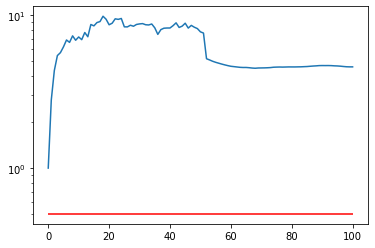

0.9985325333515306

In [591]:
true_weights = np.random.normal(0, 1, size=(dimension,))
true_weights /= np.linalg.norm(true_weights, ord=2)
#x = make_low_rank_matrix(n_samples=T, n_features=dimension,effective_rank=50, random_state=n)
#x /= np.linalg.norm(x, ord=2, axis=1, keepdims=True)

cond, x = result[8.148089946245888]

y = x @ true_weights

h = 1e-4
max_iter = 100
lbd = 1e-3

langevin = LMC(dimension, eta, lbd)
vi_approx = VI_gaussian(dimension, eta, lbd,  approx=True)
vi_non_approx = VI_gaussian(dimension, eta, lbd,  approx=False)

distances = langevin.run(x, y, h, max_iter, eps)

plt.plot(distances)
plt.hlines(0.5, 0, max_iter, 'r')
plt.yscale('log')
plt.show()
np.min(distances)

In [497]:
import pickle as pkl
def generate_data(T, dimension, rank, true_weights):
    x = make_low_rank_matrix(n_samples=T, n_features=dimension,effective_rank=rank)
    x /= np.linalg.norm(x, 2, axis=1, keepdims=True)
    y = x @ true_weights
    return x, y

def compute_condition_number(x):
    Sigma = eta * (lbd*np.eye(dimension) + x.T@x)
    return np.linalg.cond(Sigma) 

eps = 0.01
conditions = np.array([1, 2, 3, 4])
result = {}
for n in tqdm(range(5000)):
    rank =  49 * np.random.rand() + 0.5
    x = make_low_rank_matrix(n_samples=T, n_features=dimension,effective_rank=rank, random_state=n)
    x /= np.linalg.norm(x, ord=2, axis=1, keepdims=True)
    cond = compute_condition_number(x)
    idx = np.argwhere(np.abs(cond - conditions) / conditions < eps)
    if len(idx) == 1:
        result[conditions[idx[0]][0]] = (cond, x)
        
result.keys()
pkl.dump(result, open('data.pkl', 'wb'))

In [498]:
print(sorted(list(result.keys())))

[3, 4]


In [566]:
result = {}
for rank in [41, 33, 27, 20, 15, 12]:
    x = make_low_rank_matrix(n_samples=T, n_features=dimension,effective_rank=rank, random_state=2)
    x /= np.linalg.norm(x, ord=2, axis=1, keepdims=True)
    cond = compute_condition_number(x)
    result[cond] = (cond, x)

In [567]:
result.keys()

dict_keys([3.0284609692254887, 4.026679798183276, 4.966267182198532, 6.022170286257623, 7.021455870035063, 8.148089946245888])

In [541]:
# 41 -> 3
# 33 -> 4
# 27 -> 5
# 20 -> 6
# 15 -> 7
# 12 -> 8


In [565]:
x = make_low_rank_matrix(n_samples=T, n_features=dimension,effective_rank=12, random_state=n)
x /= np.linalg.norm(x, ord=2, axis=1, keepdims=True)
compute_condition_number(x)

8.154683515683523

In [508]:
r = []
for n in tqdm(range(1000)):
    #rank = 49 * np.random.rand() + 0.5
    x = make_low_rank_matrix(n_samples=T, n_features=dimension,effective_rank=5, random_state=n)
    x /= np.linalg.norm(x, ord=2, axis=1, keepdims=True)
    r.append(compute_condition_number(x))

KeyboardInterrupt: 

In [ ]:
np.min(r)

In [ ]:
plt.hist(r, bins=100)
plt.xscale('log')
plt.show()

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
class LMC(object):
    def __init__(self, dimension):
        self.dimension = dimension
        
    def gradient(self, theta, mean, cov_inv):
        return  2 * cov_inv @ (theta - mean)
        
    def update(self, theta, gradient, h):
        noise = np.random.normal(0, np.sqrt(2 * h), size=(self.dimension,))
        return theta - h * gradient +  noise 
        
    def run(self, h, max_iter, mean, cov_inv):
        theta = np.random.normal(0, 1, size=(self.dimension,))
        thetas = [theta]
        for nb_iter in range(max_iter):
            grad = self.gradient(theta, mean, cov_inv)
            theta = self.update(theta, grad, h)
            thetas.append(theta)
        return np.array(thetas)

class VIGaussian(object):

    def __init__(self, dimension):
        self.dimension = dimension

    def gradient(self, theta, mean, cov_inv):
        return  2 * cov_inv @ (theta - mean)
        
    def update_mean(self, mean, gradient, h):
        return mean - h * gradient
    
    def update_cov(self, cov_semi, cov_semi_inv, cov_post_in, h):
        cov_semi = (np.eye(self.dimension) - 2 * h * cov_post_in) @ cov_semi + h * cov_semi_inv.T
        cov_semi_inv = np.linalg.pinv(cov_semi)
        return cov_semi, cov_semi_inv
    
    def sample(self, mean, cov_semi):
        eps = np.random.normal( size=(self.dimension, 1))
        theta = mean.T + (cov_semi @ eps).squeeze()
        return  theta.squeeze()
    
    def run(self, h, max_iter, mean_post, cov_inv_post):
        mean = np.zeros(self.dimension)
        cov_semi = np.eye(self.dimension)
        cov_semi_inv = np.eye(self.dimension)
        thetas = []
        for nb_iter in range(max_iter):
            theta = self.sample(mean, cov_semi)
            thetas.append(theta)
            grad = self.gradient(theta, mean_post, cov_inv_post)
            mean = self.update_mean(mean, grad, h)
            cov_semi, cov_semi_inv = self.update_cov(cov_semi, cov_semi_inv, cov_inv_post, h)
        return np.array(thetas)
   

In [64]:
def generate_cov_matrix(dimension, cond):
    x = np.random.normal(0, 1, size=(dimension, 100))
    x /= np.linalg.norm(x, ord=2, axis=1, keepdims=True)
    M = x @ x.T
    values, vector = np.linalg.eig(M)
    values = values.real
    vector = vector.real
    D = np.diag(np.linspace(1/cond, 1, dimension))
    return vector @ D @ vector.T


def run_exp(mean_post, dimension, condition_numbers):
    
    for cond in condition_numbers:
        cov_post = generate_cov_matrix(dimension, cond)
        
    
cov = generate_cov_matrix(50, 5)
np.linalg.cond(cov)

5.000000000000001

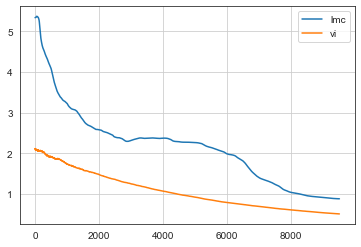

In [125]:
dimension = 2
cond = 1
h = 1e-4

cov_post = generate_cov_matrix(dimension, cond)
cov_inv_post = np.linalg.inv(cov_post)

mean_post = np.random.normal(0, 1, size=(dimension,))
langevin = LMC(dimension)
thetas_lmc = langevin.run(h, 10000, mean_post, cov_post)
vi = VIGaussian(dimension)
thetas_vi = vi.run(h, 10000, mean_post, cov_post)


def get_kl(k, samples, mean, cov, cov_inv):
    kl = []
    for n in tqdm(range(500, len(samples))):
        sub_sample = samples[: n]
        m1 = np.mean(sub_sample)
        #kl.append(np.linalg.norm(mean - m1))
        cov1 = np.cov(sub_sample.T)
        det_post = np.linalg.det(cov)
        det = np.linalg.det(cov1)
        kl.append(0.5 * (np.log(det_post / det) - k + (m1 - mean).T @ cov_inv @ (m1 - mean) + np.trace(cov_inv @ cov1)))
    return kl
    
    
plt.plot(get_kl(dimension, thetas_lmc, mean_post, cov_post, cov_inv_post), label='lmc')
plt.plot(get_kl(dimension, thetas_vi, mean_post, cov_post, cov_inv_post), label='vi')
plt.legend()
plt.grid()
plt.show()

In [100]:
info = {}
info['mean_post'] = np.array([1, 2])
info['cov_post'] = np.array([[10, 0], [0, 1]])
info['cov_inv_post'] = np.linalg.inv(info['cov_post'])



def sample(info, n):
    return np.random.multivariate_normal(mean_post, cov=cov_post, size=(n,))


thetas = sample(info, 10000)

In [3]:
langevin = LMC(2)
thetas_lmc = langevin.run(1e-4, 10000, info['mean_post'], info['cov_inv_post'])
vi = VIGaussian(2)
thetas_vi = vi.run(1e-4, 10000, info['mean_post'], info['cov_inv_post'])

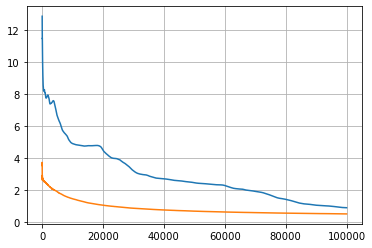

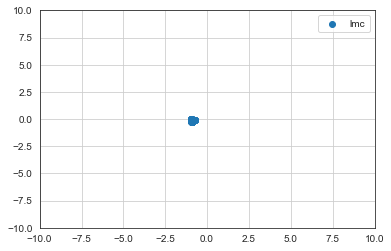

In [104]:
plt.scatter(thetas_lmc[:, 0], thetas_lmc[:, 1], label='lmc')
#plt.scatter(thetas[:, 0], thetas[:, 1], label='post')
#plt.scatter(thetas_vi[:, 0], thetas_vi[:, 1], label='vi')
plt.legend()
plt.xlim((-10, 10))
plt.ylim((-10, 10))
plt.grid()
plt.show()

ok
ok
ok


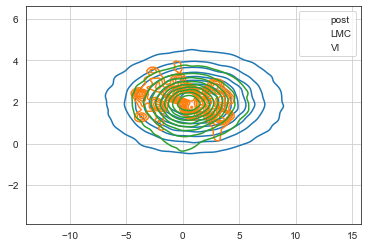

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.kdeplot(x=thetas[:, 0], y=thetas[:, 1], label='post')
print('ok')
sns.kdeplot(x=thetas_lmc[:, 0], y=thetas_lmc[:, 1], label='LMC')
print('ok')
sns.kdeplot(x=thetas_vi[:, 0], y=thetas_vi[:, 1], label='VI')
print('ok')
plt.grid()
plt.legend()
plt.show()